# Solutions for Lab Sheet 6 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-6-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd
import scipy.signal as sig

## Helper Function to Calculate Next-Power-of-2

### Background information

We will use the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform "Click for additional details on the FFT on Wikipedia") in this notebook to calculate [spectra](https://en.wikipedia.org/wiki/Spectrum "Click for additional details on spectra on Wikipedia"). One important parameter of the FFT is the FFT length $L_{\mathrm{FFT}}$. For determining a proper FFT length $L_{\mathrm{FFT}}$ we are interested in a number which is higher than the length of our time domain (input) sequence. *The FFT* is usually implemented as a collection of numerous algorithms calculating the [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform "Click for additional details on the DFT on Wikipedia") efficiently for various types and lengths of input signals, often using the software library [FFTW](https://en.wikipedia.org/wiki/FFTW "Click for additional details on the FFTW on Wikipedia"). At runtime, an efficient algorithm for a signal type  (e.g., real-valued, complex-valued, ...) and length $L_{\mathrm{FFT}}$ is chosen. 

A power of $2$ is beneficial to allow the use of the efficient [Cooley–Tukey FFT algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm "Click for additional details on the Cooley-Tuckey Algorithm on Wikipedia") or [Radix-2 implementation](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm "Click for additional details on the Cooley-Tuckey Algorithm and Radix-2 implementation on Wikipedia") for the `fft()`. Therefore, we will use the following helper function to determine the next-power-of-2 ragarding a length of a signal. How this function works exactly is beyond the scope of this lecture, but you should be able to use it.

### Function to calculate Next-Power-of-2

The following function `nextPowerOf2(L)` calculates an appropriate FFT length `L_FFT` which is a power of $2$ and is always longer than the signal length $L$. Play around with different $L$, e.g. by using the example provided in the main comment in the code below.

```python
for L in range(20):
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))
```

In [2]:
def nextPowerOf2(L):
    '''
    Calculates the smallest power of 2 which is bigger than input variable n
    
    This helper function can be used to calculate an appropriate 
    length for an DFT which is longer than the signal length n and a power of 2.
    
    Input:
        L: int
            signal length
    Output:
        p: integer which is greater or equal than n and a power of 2
    
    Examples:
        for L in range(20):
            print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))
            
        x=ones(11)
        L_FFT=nextPowerOf2(len(x))
    '''
    if (L<2):
        return 2
    # If n is a power of 2 then return n 
    if (L and not(L & (L - 1))):
        return L
    # If n is NOT a power of 2 
    p = 1
    while (p < L) :
        p <<= 1 
    return p

In [3]:
for L in range(20):
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))

nextPowerOf2(L) for L=0 is 2
nextPowerOf2(L) for L=1 is 2
nextPowerOf2(L) for L=2 is 2
nextPowerOf2(L) for L=3 is 4
nextPowerOf2(L) for L=4 is 4
nextPowerOf2(L) for L=5 is 8
nextPowerOf2(L) for L=6 is 8
nextPowerOf2(L) for L=7 is 8
nextPowerOf2(L) for L=8 is 8
nextPowerOf2(L) for L=9 is 16
nextPowerOf2(L) for L=10 is 16
nextPowerOf2(L) for L=11 is 16
nextPowerOf2(L) for L=12 is 16
nextPowerOf2(L) for L=13 is 16
nextPowerOf2(L) for L=14 is 16
nextPowerOf2(L) for L=15 is 16
nextPowerOf2(L) for L=16 is 16
nextPowerOf2(L) for L=17 is 32
nextPowerOf2(L) for L=18 is 32
nextPowerOf2(L) for L=19 is 32


## The Chirp Signal, a.k.a. Sweep Signal

The function 
\begin{equation}
\label{eq:simpleChirp}
x_{\mathrm{chirp}}(t)=\mathrm{sin}\left(\pi t^2\right) \tag{1}
\end{equation}
defines a so-called **linear-frequency [chirp](https://en.wikipedia.org/wiki/Chirp "Click here for additional information on the Chirp signal on Wikipedia")** or simply linear chirp. It is a signal that sweeps through diffrent frequencies over time.

The instantaneous frequency $f(t)$ of this chirp signal increases exactly linearly with time, i.e. $f(t)=f_0+ a t$ with a constant $a=\frac{f_1-f_0}{t_1-t_0}$. More precisely, the instantaneous angular frequency $f(t)$ of the chirp signal at time $t$ is the derivate of the sinusoid's argument divided by $2\pi$, thus $f(t) = t$. 

The following function `generate_chirp()` implements (\ref{eq:simpleChirp}) and the successive code cell uses this function to generate a chirp signal from $t_1=0$ seconds to $t_2=8$ seconds.

In [4]:
def generate_chirp(t1=0,t2=10,fs=8000):
    '''
    Generates a chirp signal by implementing $x(t)=sin(\pi t^2)$
    
    Input:
        t1: float, optional
            start time (in seconds), default: start at 0 seconds
        t2: float, optional
            end time (in seconds), default: end at 10 seconds
        fs: float, optional
            sampling frequency in Hz, default: 8000 Hz
    Output:
        chirp signal
    
    Example use:
        x=generate_chirp(50,70,fs)
    '''
    length=t2-t1 # signlal length in seconds
    t = np.linspace(t1, t2, length*fs) # time vector from t1 to t2
    return np.sin(np.pi*t**2)

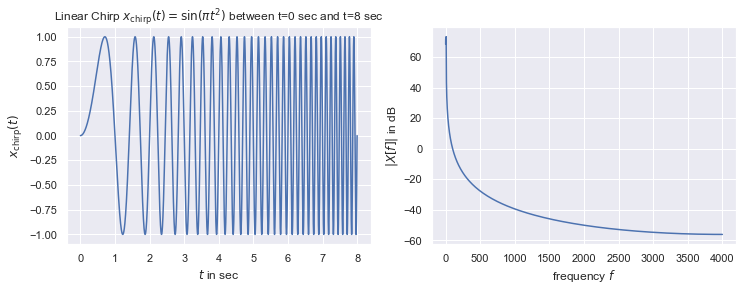

In [5]:
fs=8000      # sampling frequency
t1=0         # time 1 in seconds (start time)
t2=8         # time 2 in seconds (end time)

# use our function to generate the chirp signal
x=generate_chirp(t1,t2,fs)

# plot chirp signal
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
t = np.linspace(t1, t2, (t2-t1)*fs) # time vector from t1 to t2 for plotting
plt.plot(t,x)
plt.ylabel('$x_{\mathrm{chirp}}(t)$')
plt.xlabel('$t$ in sec')
plt.title('Linear Chirp $x_{\mathrm{chirp}}(t)=\mathrm{sin}(\pi t^2)$ between t='+str(t1)+' sec and t='+str(t2)+' sec')

# compute and plot magnitude spectrum
L_FFT=nextPowerOf2(len(x))
X = np.fft.rfft(x,n=L_FFT)
f = np.fft.rfftfreq(L_FFT, d=1./fs)

plt.subplot(1,2,2)
plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel('frequency $f$')
plt.ylabel('$|X[f]|$ in dB')
#plt.ylim([0, 50])
plt.grid(True)


# listen to the sound file
ipd.Audio(x, rate=fs)

The left panel of the figure above shows the generated chirp signal in time domain. A sinusoidal signal with increasing frequency over time (i.e., faster oscillations for later times $t$) is visible. The spectrum seems to be more difficult to interpret at the moment and the audio is not perceivable, but hopefully this gets clear when we experiment further.

To get more insight what happens in the fequency domain let's use the `xlim()` command to zoom into the frequency plot in the right panel above.

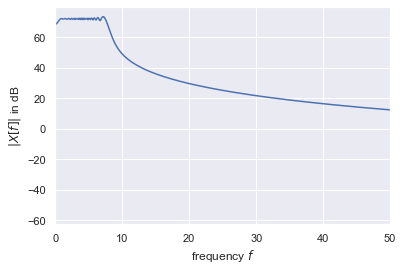

In [6]:
plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel('frequency $f$')
plt.ylabel('$|X[f]|$ in dB')
plt.xlim([0, 50])
plt.grid(True)

We now see that actually a frequency range exists which is (more or less) flat (roughly between $0$ Hz and $\approx 8$ Hz) which is in line with the derivation of the instantaeous frequency derived above, i.e $f(t) = t$.

Note: You audio equipment (loudspeaker or headphones) can not reproduce signal with such low frequencies. This is the reason why no sound is perceived during playback of the generated chirp signal.

Let's analyse a sweep for time parameters $t_1=50$ seconds to $t_2=100$ seconds in the following.

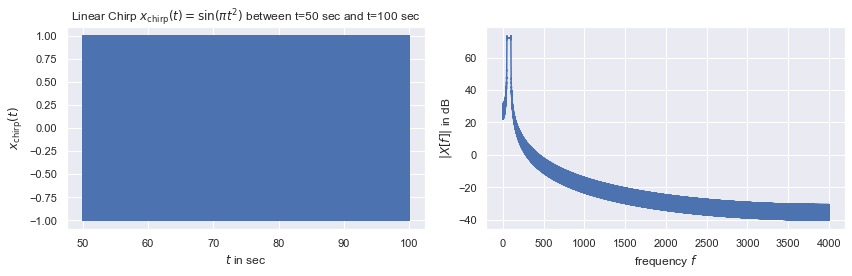

In [7]:
t1=50        # time 1 in seconds (start time)
t2=100       # time 2 in seconds (end time)

# use our function to generate the chirp signal
x=generate_chirp(t1,t2,fs)

# plot chirp signal
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
t = np.linspace(t1, t2, (t2-t1)*fs) # time vector from t1 to t2
plt.plot(t,x)
plt.ylabel('$x_{\mathrm{chirp}}(t)$')
plt.xlabel('$t$ in sec')
plt.title('Linear Chirp $x_{\mathrm{chirp}}(t)=\mathrm{sin}(\pi t^2)$ between t='+str(t1)+' sec and t='+str(t2)+' sec')

# compute and plot magnitude spectrum
L_FFT=nextPowerOf2(len(x))
X = np.fft.rfft(x,n=L_FFT)
f = np.fft.rfftfreq(L_FFT, d=1./fs)

plt.subplot(1,2,2)
plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel('frequency $f$')
plt.ylabel('$|X[f]|$ in dB')
#plt.ylim([0, 50])
plt.grid(True)

plt.tight_layout()

# listen to the sound file
ipd.Audio(x, rate=fs)

The left panel (chirp signal in time domain) is now no longer very intuitive because there are too many oscillations for the given length of the signal. 

However, now we should be able to perceive the signal during playback. When you listen to the signal for a certain time you should be able to perceive the increasing frequency. Note that the length of the signal is $t_1-t_2=20$ seconds.
Looking at the spectrum we now already see that there is a frequency range in which the spectrum is flat.

Again we zoom in for the spectral plot:

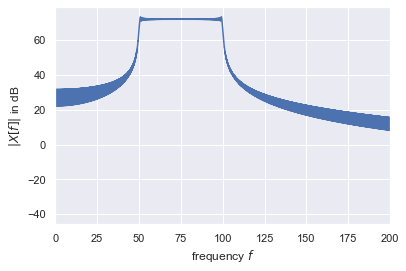

In [8]:
plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel('frequency $f$')
plt.ylabel('$|X[f]|$ in dB')
plt.xlim([0, 200])
plt.grid(True)

Again, we see that the spectrum is flat in the analysed frequency range.

Let's try $t_1=300$ seconds to $t_2=400$ seconds.

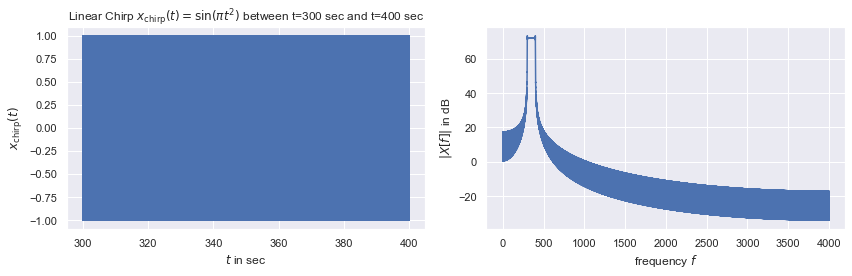

In [9]:
t1=300       # time 1 in seconds (start time)
t2=400       # time 2 in seconds (end time)

# use our function to generate the chirp signal
x=generate_chirp(t1,t2,fs)

# plot chirp signal
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
t = np.linspace(t1, t2, (t2-t1)*fs) # time vector from t1 to t2
plt.plot(t,x)
plt.ylabel('$x_{\mathrm{chirp}}(t)$')
plt.xlabel('$t$ in sec')
plt.title('Linear Chirp $x_{\mathrm{chirp}}(t)=\mathrm{sin}(\pi t^2)$ between t='+str(t1)+' sec and t='+str(t2)+' sec')

# compute and plot magnitude spectrum
L_FFT=nextPowerOf2(len(x))
X = np.fft.rfft(x,n=L_FFT)
f = np.fft.rfftfreq(L_FFT, d=1./fs)

plt.subplot(1,2,2)
plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel('frequency $f$')
plt.ylabel('$|X[f]|$ in dB')
#plt.ylim([0, 50])
plt.grid(True)

plt.tight_layout()

# listen to the sound file
ipd.Audio(x, rate=fs)

The frequency range is again higher (compared to the previous two examples), the frequency range through which the chirp sweeps is flat.

Note: The frequency plot (correctly) shows a flat spectrum, but we perceive that the signal is a sine, i.e. a signal with only one frequency, but varying (sweeping through the chosen frequency range) over time. Therefor, I will make sense to anaylse spectral and time bahaviour simultaneously in the following.

### Tasks 2 and 3 - SciPy's Chirp Function

The (chirp) signals created so far vary frequency with fixed *speed*. The `scipy.signal` library provides a function `chirp()` which is more flexible than the function we created before. See e.g. [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.chirp.html) for a documentation.

The following code creates and visualises a chirp signal between $f_0=10$ Hz at $t_0=0$ seconds and $f_1=6$ Hz at $t_1=5$ seconds. Note that this the length of the length of the generated signal can be different from $t_1$.

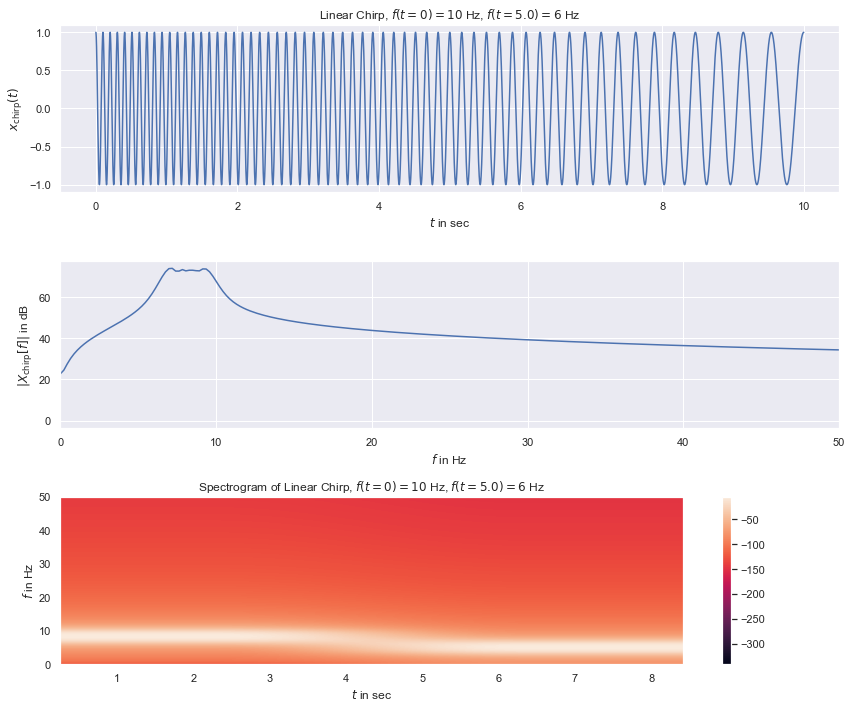

In [10]:
fs=8000   # sampling frequency
length=10 # signlal length in seconds

t = np.linspace(0, length, length*fs) # time vector

f0 = 10         # frequency in Hz at time t_0=0
f1 = 6          # frequency in Hz at time t_1
t1 = 0.5*length # frequency in Hz at time t=0
x = sig.chirp(t, f0=f0, f1=f1, t1=t1, method='linear')

# plot time domain chirp
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(t, x)
plt.title('Linear Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$x_{\mathrm{chirp}}(t)$')
plt.xlabel('$t$ in sec')

# compute and plot magnitude spectrum

L = 4*9192        # DFT length (we need a relatively large number here for high frequency resolution)
overlap = 4096  # also large overlap to get some time resolution between segments

plt.subplot(3,1,2)
f = np.fft.rfftfreq(L, 1/fs)
plt.plot(f, 20*np.log10(abs(np.fft.rfft(x,L))))
plt.xlim([0, 50])
plt.xlabel('$f$ in Hz')
plt.ylabel('$|X_{\mathrm{chirp}}[f]|$ in dB')
plt.grid(True)

# plot spectrogram of chirp
plt.subplot(3,1,3)
plt.specgram(x,NFFT=L, Fs=fs, noverlap=overlap)
plt.colorbar()  # add a colorbar to the spectrogram
plt.ylim(0,50)
plt.grid(False)
plt.title('Spectrogram of Linear Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$f$ in Hz')
plt.xlabel('$t$ in sec')

plt.tight_layout()

ipd.Audio(x, rate=fs) # this will not be audible since frequency range is too low.

The plots above visualise the time domain signal $x_{\mathrm{chirp}}(t)$ (top panel), the spectrum $|X_{\mathrm{chirp}}[f]|$ (middle panel) and the spectrogram (lower panel), i.e. how the chirp (it's spectrum) develops over time.

Please note that the frequency range for the chirp generated above is again too low to perceive a sound signal when playback.

The following code generates and visualises the chirp for time and frequency variables changed to $f_0 = 100$ Hz, $f_1 = 3$ kHz and $t_1 = 10$ seconds.

Note the removal of the `ylim()` command to zoom into the spectrogram in frequency direction and therefore adaptation of parameters of the spectrogram.

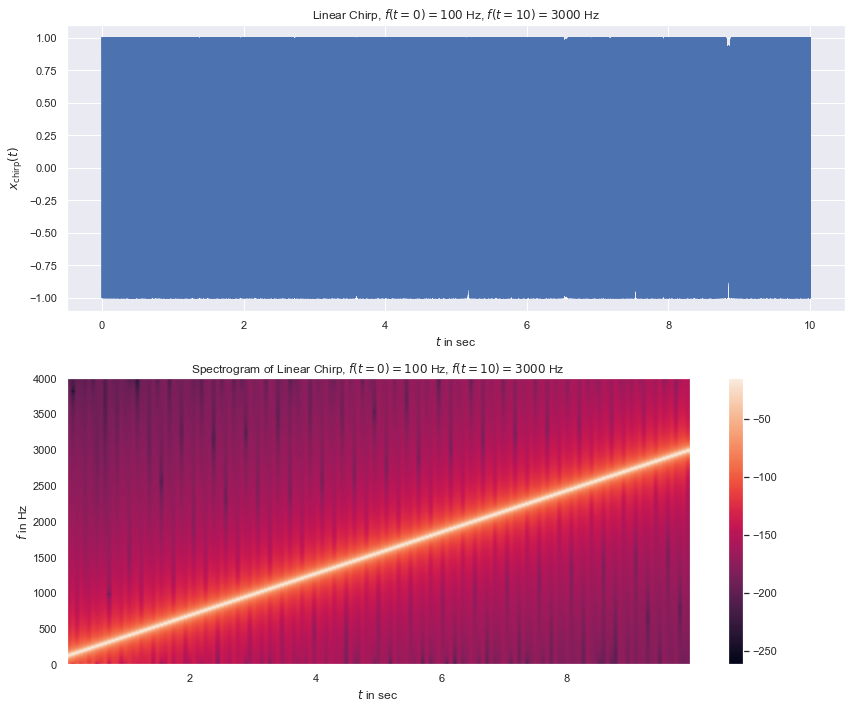

In [11]:
fs=8000   # sampling frequency
length=10 # signlal length in seconds

t = np.linspace(0, length, length*fs) # time vector

f0 = 100    # frequency in Hz at time t_0=0
f1 = 3000   # frequency in Hz at time t_1
t1 = length # frequency in Hz at time t=0

x = sig.chirp(t, f0=f0, f1=f1, t1=t1, method='linear')

# plot time domain chirp
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(t, x)
#plt.plot(t[0:2*1280], chp2[0:2*1280]) # only show the initial samples of the chirp
plt.title('Linear Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$x_{\mathrm{chirp}}(t)$')
plt.xlabel('$t$ in sec')

# plot spectrogram of chirp
L = 1024        # DFT length (since we don't want to zoom in we can take relatively 'normal' values)
overlap = 512  

plt.subplot(2,1,2) 
plt.specgram(x,NFFT=L, Fs=fs, noverlap=overlap)
plt.colorbar()  # add a colorbar to the spectrogram
#plt.ylim(0,50) 
plt.grid(False)
plt.title('Spectrogram of Linear Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$f$ in Hz')
plt.xlabel('$t$ in sec')

plt.tight_layout()

ipd.Audio(x, rate=fs)

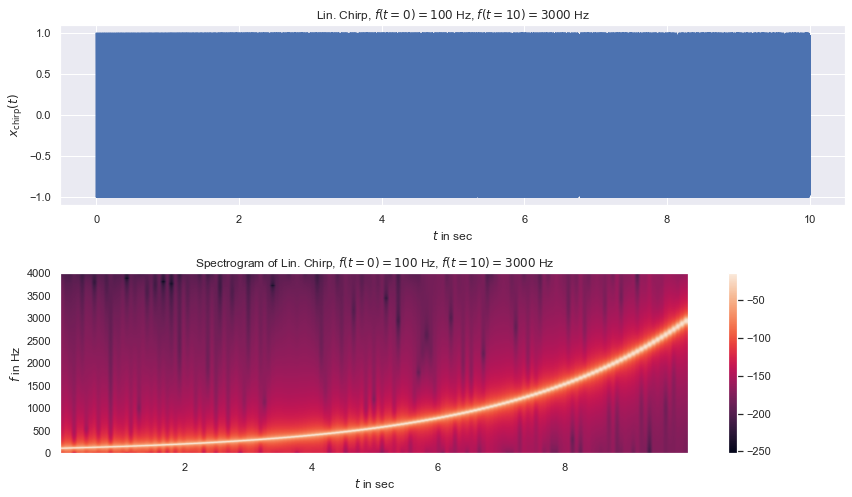

In [12]:
fs=8000   # sampling frequency
length=10 # signlal length in seconds

t = np.linspace(0, length, length*fs) # time vector

f0 = 100     # frequency in Hz at time t_0=0
f1 = 3000    # frequency in Hz at time t_1
t1 = length  # frequency in Hz at time t=0

x = sig.chirp(t, f0=f0, f1=f1, t1=length, method='logarithmic')

plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
#plt.plot(t[0:2*1280], x[0:2*1280]) # only show the initial samples of the chirp
plt.plot(t, x)                         # show the whole (time domain) signal
plt.xlabel('$t$ in sec')
plt.title('Lin. Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$x_{\mathrm{chirp}}(t)$')

# compute and plot magnitude spectrum

L = 1024       # DFT length (we need a relatively large number here for high frequency resolution)
overlap = 512  # also large overlap to get some time resolution between segments

# plot spectrogram of chirp
plt.subplot(3,1,2)
#plt.specgram(x,Fs=fs)
plt.specgram(x,NFFT=L, Fs=fs, noverlap=overlap)
plt.colorbar()  # add a colorbar to the spectrogram
#plt.ylim(0,50)
plt.grid(False)
plt.title('Spectrogram of Lin. Chirp, $f(t=0)='+str(f0)+'$ Hz, $f(t='+str(t1)+')='+str(f1)+'$ Hz')
plt.ylabel('$f$ in Hz')
plt.xlabel('$t$ in sec')

plt.tight_layout()

ipd.Audio(x, rate=fs)

### Optional: Colorbars for Spectrograms and Controlling the Colorbar

When looking at the plots above we might want to properly align the time axes and place the colour bar. Unfortunately `matplotlib` is not very user friendly in this respect.

Using the module `gridspec` allows to align plots that have elements with and without a colorbar. This is demonstrated by the following example, which uses the gridspec-constructor with keywords specified by the dictionary gridspec_kw. This dictionary, in turn, is one of the parameters of plt.subplots, which creates a figure and a set of subplots.

Basically, 4 axes are created and the left two are used for the time domain signal (upper left) and the spectrogram (lower left). The lower right is used for plotting the colorbar and the upper right is left empty.

In [13]:
# let's create a signal again

fs=8000   # sampling frequency
length=10 # signlal length in seconds

t = np.linspace(0, length, length*fs) # time vector

f0 = 100    # frequency in Hz at time t_0=0
f1 = 3000   # frequency in Hz at time t_1
t1 = length # frequency in Hz at time t=0

x = sig.chirp(t, f0=f0, f1=f1, t1=t1, method='linear')

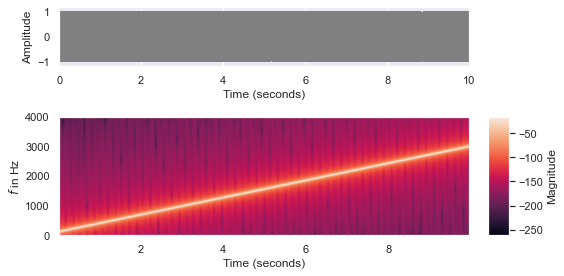

In [14]:
# create time-frequency plot with properly placed colourbar

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios':  [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(8, 4))
ax[0, 0].plot(t, x, color='gray')
ax[0, 0].set_xlabel('Time (seconds)')
ax[0, 0].set_ylabel('Amplitude')

ax[0, 0].set_xlim([min(t), max(t)])   # display the whole signal
#ax[0, 0].set_xlim([0, 0.75]) # only display the first 0.75 sec
ax[0, 0].set_ylim([-1.2, 1.2])
ax[0, 1].set_axis_off() # do not display the axis in right upper corner


spec,_,_,im = ax[1, 0].specgram(x,NFFT=1024, Fs=fs, noverlap=512)
#im = ax[1, 0].imshow(10*np.log10(spec), aspect='auto', origin='lower', extent=[t1, t2, 0, 50])
plt.colorbar(mappable=im, cax=ax[1, 1])
ax[1, 0].set_xlabel('Time (seconds)')
ax[1, 0].set_ylabel('$f$ in Hz')
ax[1, 0].grid(False)
ax[1, 1].set_ylabel('Magnitude')

plt.tight_layout()

## Creating the Spectrogram Step-by-Step (Task 4)

The magnitude $|x[n, \ell]|$ of the STFT for all frequency points $n$ and frames / blocks $\ell$ is known as the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of a signal. It is frequently used to analyze signals in the time-frequency domain, for instance by a [spectrum analyzer](https://en.wikipedia.org/wiki/Spectrum_analyzer). It can be interpreted as a *image* of the signal with (block) time direction on the $x$ axis and (discrete) frequency $n$ on the y axis.

From Lab Sheet 3 we already know how to break a long signal into block, a.k.a. frames.

<br>
<a id='task_4'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 4: Manual Spectrogram Calculation**
    
<ul>
    <li> 
        Split the input sequence into blocks of length $L_{\mathrm{DFT}}$. These may be overlapping. We solved this task already in Lab Sheet 3. Note: as an input signal $x[k]$ you may either want to load a WAVE file or just take a chirp signal already generated above.
    </li>
    <li> 
        Multiply every frame with a window function $w[k]$. You can create a window using the function <code>np.hamming(L)</code>. The window should have the same length $L_{\mathrm{DFT}}$ as your frame.
    </li>
    <li> 
        Transform every windowed frame to the frequency domain using the <code>fft()</code>.
    </li>
    <li> 
        Concatenate the resulting spectra to a spectrogram and display the resulting spectrogram. You can use <code>matplotlib</code>'s <code><a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html">imshow()</a></code> function for manually plotting the spectrogram image. Note that a spectrogram is usally shown in dB scaling.
    </li>
</ul>
</div>

The following function `calc_Xn()` implements the DFT quation
\begin{equation}
\mathrm{DFT}\{x[k]\}   =  X[n] = \frac{1}{L_{\mathrm{DFT}}} \sum \limits_{k=0}^{L_{\mathrm{DFT}}-1} x[k]  e^{j 2 \pi k n /L_{\mathrm{DFT}}} \tag{2}
\end{equation}
for one discte frequency point $n$.

In [15]:
def calc_Xn(xk,n):
    '''
    Implementation of the Discrete Fourier Transform (DFT) formula.
    Calculates the Fourier coefficient X[n] for one discrete frequency n 
    
    Input: 
    xk: time domain signal vector
     n: discrecte frequency to be calculated
    
    Output 
    Xn : frequency domain point 
    '''
    L_DFT  = len(xk)
    k_vec = np.arange(0,L_DFT,1)
    Xn = np.sum(xk*np.exp((1j*2*np.pi*k_vec*n)/L_DFT))/L_DFT
    return(Xn)

To obtain the full (magnitude) spectrum for all frequency points $n=0,...,L_{\mathrm{DFT}}/2$ of interest, we implement a function `calc_Manitude_Spectrum()`, which calls the function `calc_Xn()` for the selected $n$ to calculate the spectral point $X[n]$. Please note that we only calculate the first half the spectrum, i.e. the *positive frequencies* up to $L_{\mathrm{DFT}}/2$.

In [16]:
def calc_Manitude_Spectrum(xk):
    '''
    Compute Fourier coefficients up to the Nyquest Limit (fs/2), i.e. Xn for n=1,...,L_DFT/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(xk)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(calc_Xn(xk,n))*2)
    return(mag)

The following function `create_spectrogram()` takes a time domain sequence $x[k]$ as input, implements framing by creating (overlapping) blocks. For each block (starting at index `start` and of length `L_DFT` (see line $16$)), the spectrum vector, i.e. the spectrum for this one frame is calculated.

In [17]:
def create_spectrogram(x, L_DFT=512, noverlap = None):
    '''
           x: original time series
       L_DFT: The number of data points used in each block for the DFT. The default value is 256. 
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    # implement overlapping (if needed)
    if noverlap is None:
        noverlap = L_DFT/2   # hop size, 50% overlap as default
    noverlap = int(noverlap)
    
    starts  = np.arange(0,len(x),L_DFT-noverlap,dtype=int)
    # remove any window with less than L_DFT sample size
    starts  = starts[starts + L_DFT < len(x)]
    Xns = []
    for start in starts:
        # short term discrete fourier transform for a frame 
        ts_window = calc_Manitude_Spectrum(x[start:start + L_DFT]) 
        Xns.append(ts_window)
    specX = np.array(Xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

The following function plots the spectrogram created using the `matplotlib` function `plt.imshow()`. It sets a pre-defined number of x-tick (time) labels and y-tick (frequency) labels.

In [18]:
def plot_spectrogram(spec, x, fs, L, starts, mappable = None):
    '''
           x: original time series
       L_DFT: The number of data points used in each block for the DFT. The default value is 256. 
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    plt.figure(figsize=(20,8))
    
    # plot the actual spectrogram using the function plt.imshow()
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10  # number of y-ticks (labels) we want
    y_tick_pos     = np.linspace(0,spec.shape[0],Nyticks) # y-tick positions
    y_tick_labels  = ["{:4.2f}".format(i) for i in np.linspace(0,fs/2,Nyticks)] # y-tick texts
    plt.yticks(y_tick_pos,y_tick_labels) # set y-ticks
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 4 # number of x-ticks (labels) we want
    x_tick_pos = np.linspace(0,spec.shape[1],Nxticks)
    total_ts_sec = len(x)/fs
    x_tick_labels  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(x),Nxticks)]
    plt.xticks(x_tick_pos,x_tick_labels)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L_DFT={}, Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.grid(False)
    
    return(plt_spec)

Let's apply ths function to plot the spectrum to a signal.

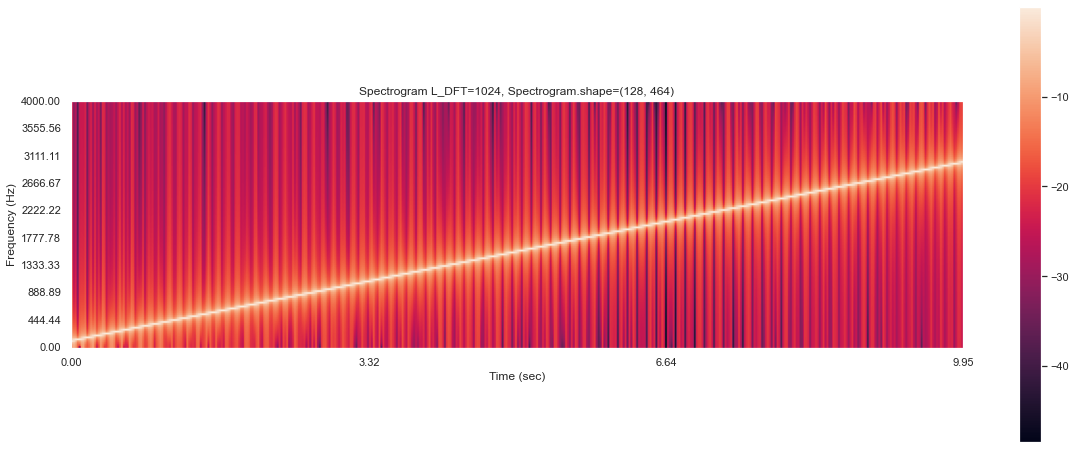

In [19]:
L_DFT    = 256
noverlap = 84
starts, spec = create_spectrogram(x, L_DFT, noverlap = noverlap)
plot_spectrogram(spec, x, fs, L, starts);

The *build-in* functions, e.g. `plt.specgram()` again are more flexible and comfortable. But the created spectrogram should clearly shows the generated time-frequency content of the chirp signal.

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 